In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt
import random

## 1. Hàm tiền xử lí dữ liệu ảnh

In [3]:
def preprocess_image(
    path, target_size=96, median_kernel_size=5, adaptive_block_size=17, adaptive_C=5
):
    if adaptive_block_size % 2 == 0 or adaptive_block_size < 3:
        adaptive_block_size = max(3, adaptive_block_size + 1)
        print(f"Adjusted adaptive_block_size to {adaptive_block_size} (must be odd)")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.medianBlur(cv2.resize(img, (256, 256)), median_kernel_size)
    binary = cv2.adaptiveThreshold(
        img,
        255,  # Use gray_filtered here
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        adaptive_block_size,
        adaptive_C,
    )
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    digit = binary[y : y + h, x : x + w]

    size_max = max(w, h)
    square = np.zeros((size_max, size_max), dtype=np.uint8)
    x_offset = (size_max - w) // 2
    y_offset = (size_max - h) // 2
    square[y_offset : y_offset + h, x_offset : x_offset + w] = digit

    resized = cv2.resize(
        square, (target_size, target_size), interpolation=cv2.INTER_AREA
    )
    normalized = resized.astype("float32") / 255.0
    normalized = normalized.reshape(target_size, target_size, 1)
    return np.expand_dims(normalized, axis=0)

In [4]:
# img = preprocess_image("../dataset/raw_dataset/0/005949_0_3982.JPG")
# img_np = img.squeeze()
# plt.figure(figsize=(3, 3))
# plt.subplot(1, 1, 1)
# plt.imshow(img_np, cmap='gray')
# plt.tight_layout()
# plt.show()

## 2. Class custom dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, target_size=96):
        self.valid_data = []
        for path, label in zip(image_paths, labels):
            img = preprocess_image(path, target_size)
            if img is not None:
                self.valid_data.append((img, label))

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img, label = self.valid_data[idx]
        img_tensor = (
            torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).squeeze(0)
        )
        return img_tensor, label

## 3. Hàm load dữ liệu

In [6]:
def load_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(label_path, filename))
                labels.append(int(label))
    return image_paths, labels

## 4. Hiển thị ảnh mẫu

In [21]:
def show_first_n_images(dataset, n=5):
    plt.figure(figsize=(10, n))
    for i in range(n):
        img_tensor, label = dataset[i]
        img_np = img_tensor.squeeze().numpy()
        plt.subplot(n, 10, i + 1)
        plt.imshow(img_np, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## 5. Hàm train model

In [8]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss / len(loader):.4f}")

## 6. Hàm test độ chính xác (acc) của model

In [9]:
# ----------------------------
# 6. TEST MODEL
# ----------------------------
def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Test loss: {total_loss / len(loader):.4f} - Accuracy: {acc:.2f}%")

## 7. Hàm dự đoán ảnh chữ viết tay từ thư mục tập test

In [24]:
def predict_digits_from_folder(
    model, input_folder, output_csv, device="cpu", target_size=96
):
    model.eval()
    results = []
    i = 1
    for filename in os.listdir(input_folder):
        print(i)
        i += 1
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            print(f"⚠️ Ảnh không được hỗ trợ: {filename}. Random kết quả.")
            results.append([filename, random.randint(0, 9)])
            continue
        path = os.path.join(input_folder, filename)
        img = preprocess_image(path, target_size)
        if img is None:
            print(f"⚠️ Ảnh lỗi: {filename}. Random kết quả.")
            results.append([filename, random.randint(0, 9)])
            continue
        img_tensor = (
            torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        )
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        results.append([filename, pred])
    pd.DataFrame(results, columns=["filename", "predicted_label"]).to_csv(
        output_csv, index=False
    )
    print(f"✅ Ghi kết quả vào: {output_csv}")

## 8. Configuration

In [16]:
TRAIN_SET_DIR = "../dataset/train_set"
TEST_SET_DIR = "../dataset/test_set"
OUTPUT_CSV = "../pred.csv"
EPOCH = 20
TARGET_SIZE = 192

## 9. Chạy chương trình

### 9.1. Load dữ liệu

In [ ]:
# Load và chia dữ liệuuuuu
image_paths, labels = load_image_paths_and_labels(TRAIN_SET_DIR)
# x_train, x_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)

# Tạo Dataset
train_dataset = CustomDataset(image_paths, labels, target_size=TARGET_SIZE)
# test_dataset = CustomDataset(x_test, y_test, target_size=96)

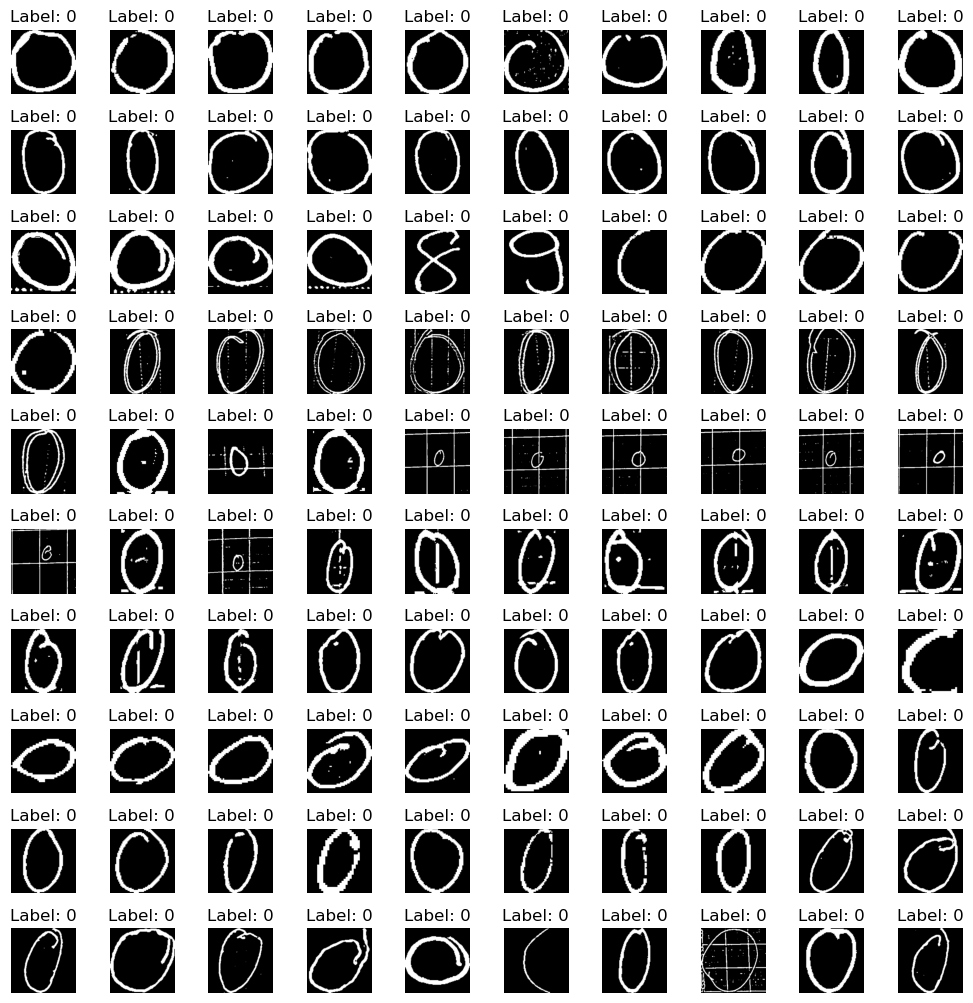

In [22]:
# Hiển thị n ânh mẫu đầu tiên
show_first_n_images(train_dataset, n=100)

### 9.2. Train

In [14]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
model = resnet18.to(device)

# Optimizer & Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train và Test
for epoch in range(EPOCH):
    print(f"\nEpoch {epoch + 1}")
    train(model, train_loader, criterion, optimizer, device)
    # test(model, test_loader, criterion, device)


Epoch 1
Train loss: 0.9871

Epoch 2
Train loss: 0.7252

Epoch 3
Train loss: 0.6212

Epoch 4
Train loss: 0.5301

Epoch 5
Train loss: 0.5184

Epoch 6
Train loss: 0.4742

Epoch 7
Train loss: 0.3859

Epoch 8
Train loss: 0.3696

Epoch 9
Train loss: 0.4138

Epoch 10
Train loss: 0.3326

Epoch 11
Train loss: 0.3358

Epoch 12
Train loss: 0.3127

Epoch 13
Train loss: 0.4849

Epoch 14
Train loss: 0.2869

Epoch 15
Train loss: 0.2678

Epoch 16
Train loss: 0.2822

Epoch 17
Train loss: 0.3824

Epoch 18
Train loss: 0.2830

Epoch 19
Train loss: 0.2766

Epoch 20
Train loss: 0.2222


### 9.3. Dự đoán

In [25]:
predict_digits_from_folder(
    model, TEST_SET_DIR, OUTPUT_CSV, device=device, target_size=TARGET_SIZE
)

1
2
3
4
5
6
7
8
9
10
11
12
13
⚠️ Ảnh không được hỗ trợ: 004d39d8a48b484ba47ac058af0307d2.HEIC. Random kết quả.
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
⚠️ Ảnh lỗi: a8af280c6d91ee9e2a52317dc4a3818d.jpg. Random kết quả.
53
54
55
56
57
58
59
60
61
62
63
64
65
⚠️ Ảnh không được hỗ trợ: 34dff8cda52938e0ba5af071f116e88c.HEIC. Random kết quả.
66
67
68
69
70
71
72
73
74
75
76
77
78
79
⚠️ Ảnh lỗi: d54555372765dcc6ca8738113fd6022b  -.jpg. Random kết quả.
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
⚠️ Ảnh không được hỗ trợ: 4f9b940f50aca0456b4b2cde2efac1e6.HEIC. Random kết quả.
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
⚠️ Ảnh lỗi: 16820f0b1e0afcb21965642067f64db6.jpg. Random kết quả.
150
151
152
153
⚠️ Ảnh không được hỗ trợ: badf3dc23c7eca5d035f6eef2c